In [1]:
import uproot4 as uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import boost_histogram as bh
import mplhep as hep
import pandas as pd

In [2]:
%%capture
# mplhep Settings
# plt.rcParams.update({
#     "text.usetex":True
# })
plt.style.use([hep.style.ATLAS])
#                {'font.sans-serif': ['Tex Gyre Heros']},  # use when helvetica isn't installed
#                {'axes.labelsize': 23},
#                {'axes.labelpad': 23},
#                {'axes.titlelocation': 'right'},
#                ])

In [3]:
filename = 'wminmunu_MC.root'

In [4]:
%time
truth = uproot.open(filename)["truth"]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [5]:
truth.keys()

['weight_mc',
 'eventNumber',
 'runNumber',
 'mu',
 'weight_pileup',
 'randomRunNumber',
 'mcChannelNumber',
 'PDFinfo_X1',
 'PDFinfo_X2',
 'PDFinfo_PDGID1',
 'PDFinfo_PDGID2',
 'PDFinfo_Q',
 'PDFinfo_XF1',
 'PDFinfo_XF2',
 'weight_pileup_hash_truth',
 'KFactor_weight_truth',
 'KFactor_bornMass_truth',
 'MC_WZ_dilep_phi_dres',
 'MC_WZ_dilep_eta_dres',
 'MC_WZ_dilep_pt_dres',
 'MC_WZ_dilep_m_dres',
 'MC_WZneutrino_phi_dres',
 'MC_WZneutrino_m_dres',
 'MC_WZmu_el_phi_dres',
 'MC_WZmu_el_eta_dres',
 'MC_WZmu_el_pt_dres',
 'MC_WZ_dilep_phi_bare',
 'MC_WZ_dilep_pt_bare',
 'MC_WZ_dilep_m_bare',
 'MC_WZ_dilep_eta_bare',
 'MC_WZneutrino_phi_bare',
 'MC_WZneutrino_eta_bare',
 'MC_WZneutrino_pt_born',
 'MC_WZmu_el_pt_born',
 'MC_WZmu_el_eta_born',
 'MC_WZneutrino_eta_dres',
 'MC_WZneutrino_m_born',
 'MC_WZneutrino_m_bare',
 'MC_WZmu_el_phi_born',
 'MC_WZmu_el_m_born',
 'MC_WZ_dilep_pt_born',
 'MC_WZneutrino_pt_dres',
 'MC_WZ_pt',
 'MC_WZneutrino_eta_born',
 'MC_WZ_eta',
 'MC_WZ_phi',
 'MC_WZneut

In [6]:
# into pandas
%time
truth_df = truth.arrays(library='pd',
                        filter_name=[
                            'MC_WZmu_el_pt_born',
                            'MC_WZneutrino_pt_born',
                            'weight_mc',
                            'MC_WZ_pt',
                        ])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [7]:
%time
# map weight column
truth_df['weight'] = truth_df['weight_mc'].map(lambda w: -1 if w < 0 else 1)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [8]:
# to GeV
GeV_cols = [
    'MC_WZneutrino_pt_born',
    'MC_WZmu_el_pt_born', 
    'MC_WZ_pt',
]
truth_df[GeV_cols] = truth_df[GeV_cols].applymap(lambda val: val / 1000)

In [9]:
truth_df.head()

,weight_mc,MC_WZneutrino_pt_born,MC_WZmu_el_pt_born,MC_WZ_pt,weight
0,8433.269531,35.049160,39.568496,20.496412,1
1,8436.570312,29.193055,28.472537,1.068551,1
2,8436.570312,36.628605,29.414922,7.622897,1
3,8433.269531,35.988871,39.994266,9.314710,1
4,8436.570312,52.495527,33.879480,25.446846,1


In [10]:
# add columns of cut booleans
truth_df['WpT_lo'] = truth_df['MC_WZ_pt'] < 50
truth_df['WpT_hi'] = truth_df['MC_WZ_pt'] > 100

In [11]:
truth_df.head()

,weight_mc,MC_WZneutrino_pt_born,MC_WZmu_el_pt_born,MC_WZ_pt,weight,WpT_lo,WpT_hi
0,8433.269531,35.049160,39.568496,20.496412,1,True,False
1,8436.570312,29.193055,28.472537,1.068551,1,True,False
2,8436.570312,36.628605,29.414922,7.622897,1,True,False
3,8433.269531,35.988871,39.994266,9.314710,1,True,False
4,8436.570312,52.495527,33.879480,25.446846,1,True,False


In [12]:
WpT_lo = truth_df[truth_df['WpT_lo']]
WpT_lo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1106013 entries, 0 to 1179999
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   weight_mc              1106013 non-null  float32
 1   MC_WZneutrino_pt_born  1106013 non-null  float64
 2   MC_WZmu_el_pt_born     1106013 non-null  float64
 3   MC_WZ_pt               1106013 non-null  float64
 4   weight                 1106013 non-null  int64  
 5   WpT_lo                 1106013 non-null  bool   
 6   WpT_hi                 1106013 non-null  bool   
dtypes: bool(2), float32(1), float64(3), int64(1)
memory usage: 48.5 MB


Text(0, 1, 'muon $p_{T}$ [GeV]')

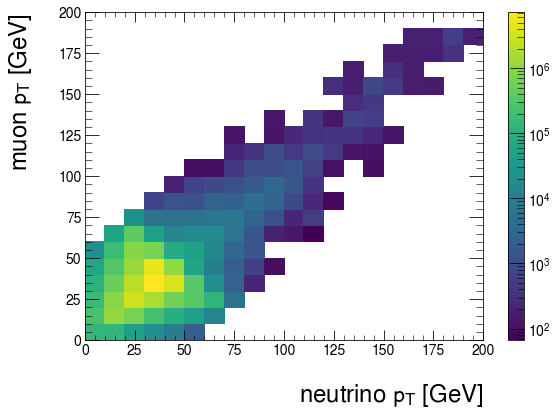

In [22]:
# Low hisogram 
hWpT_lo = bh.Histogram(bh.axis.Regular(20, 0, 200),
                       bh.axis.Regular(20, 0, 200),
)

hWpT_lo.fill(WpT_lo['MC_WZneutrino_pt_born'].to_numpy(), 
             WpT_lo['MC_WZmu_el_pt_born'].to_numpy(), 
             weight=WpT_lo['MC_WZmu_el_pt_born'].to_numpy(),
             threads=6
            )

fig, ax = plt.subplots()
mesh = ax.pcolormesh(*hWpT_lo.axes.edges.T, hWpT_lo.view().T, norm=LogNorm())
fig.colorbar(mesh)
ax.set_xlabel("neutrino $p_{T}$ [GeV]")
ax.set_ylabel("muon $p_{T}$ [GeV]")

In [15]:
WpT_hi = truth_df[truth_df['WpT_hi']][['weight_mc','MC_WZneutrino_pt_born','MC_WZmu_el_pt_born','MC_WZ_pt','weight']]
WpT_hi.head()

,weight_mc,MC_WZneutrino_pt_born,MC_WZmu_el_pt_born,MC_WZ_pt,weight
97,8433.269531,89.756922,54.618758,142.981219,1
176,8436.570312,116.797297,40.248387,134.675281,1
407,8436.950195,75.092742,67.090039,140.797000,1
487,8436.950195,74.467000,82.299273,136.323266,1
956,8438.440430,186.082094,487.077094,673.149688,1


Text(0, 1, 'muon $p_{T}$ [GeV]')

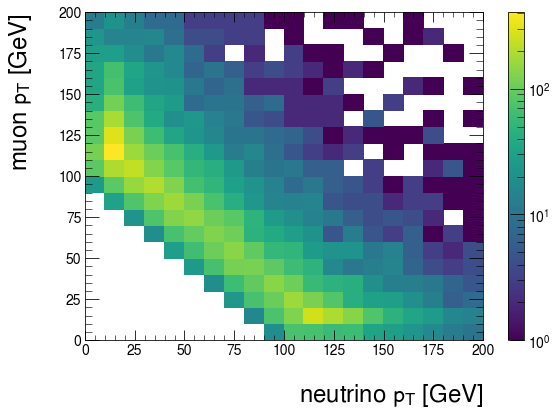

In [19]:
# high hisogram 
hWpT_hi = bh.Histogram(bh.axis.Regular(20, 0, 200),
                       bh.axis.Regular(20, 0, 200),
)

hWpT_hi.fill(WpT_hi['MC_WZneutrino_pt_born'].to_numpy(), 
             WpT_hi['MC_WZmu_el_pt_born'].to_numpy(), 
             weight=WpT_hi['weight'].to_numpy(),
             threads=6
            )

fig, ax = plt.subplots()
mesh = ax.pcolormesh(*hWpT_hi.axes.edges.T, hWpT_hi.view().T, norm=LogNorm())
fig.colorbar(mesh)
plt.xlabel("neutrino $p_{T}$ [GeV]")
plt.ylabel("muon $p_{T}$ [GeV]")